# Exploratory Analysis

To begin this exploratory analysis, first import libraries and define functions for plotting the data using matplotlib. Depending on the data, not all plots will be made. (Hey, I'm just a simple kerneling bot, not a Kaggle Competitions Grandmaster!)

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt


In [2]:
df1 = pd.read_csv('customertest.csv')
df1.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6


In [3]:
df = pd.read_csv('customertrain.csv')
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


# Prepare the data  


In [5]:
columns = ["Gender","Ever_Married","Graduated","Profession","Spending_Score"]
for feature in columns:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature])

# df = df.drop(["Segmentation","ID"], axis=1)        
df = df.drop(["ID","Gender","Age","Profession","Work_Experience","Spending_Score","Segmentation"], axis=1)        
df.head()

,Ever_Married,Graduated,Family_Size,Var_1
0,0,0,4.0,Cat_4
1,1,1,3.0,Cat_4
2,1,1,1.0,Cat_6
3,1,1,2.0,Cat_6
4,1,1,6.0,Cat_6


# Remove rows with no data  

We dont want to work with rows that do not have a Var_1 value, so lets remove them.

In [6]:
df.dropna(subset=['Var_1'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7992 entries, 0 to 8067
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Ever_Married  7992 non-null   int64  
 1   Graduated     7992 non-null   int64  
 2   Family_Size   7671 non-null   float64
 3   Var_1         7992 non-null   object 
dtypes: float64(1), int64(2), object(1)
memory usage: 312.2+ KB


# Encode Y
Use fit_transform to encode our multinomial categories into numbers we can work with. Later on, we can change back to labels with  
```
df["Var_1"] = yle.inverse_transform(df["Var_1"])
```

We can also print the list of categories as follows:  
```
print(yle.classes_)
```

In [7]:
yle = LabelEncoder()
df["Var_1"] = yle.fit_transform(df["Var_1"])
df.head()

,Ever_Married,Graduated,Family_Size,Var_1
0,0,0,4.0,3
1,1,1,3.0,3
2,1,1,1.0,5
3,1,1,2.0,5
4,1,1,6.0,5


# Fill in missing features  

An important part of regression is understanding which features are missing. We can choose to ignore all rows with missing values, or fill them in with either mode, median or mode.

- Mode = most common value
- Median = middle value
- Mean = average

Here is a handy function you can call which will fill in the missing features by your desired method. We will choose to fill in values with the average.  
After funning below, you should see 7992 with no null values.

In [8]:
def fillmissing(df, feature, method):
    if method == "mode":
        df[feature] = df[feature].fillna(df[feature].mode()[0])
        
    elif method == "median":
        df[feature] = df[feature].fillna(df[feature].median())
        
    else:
        df[feature] = df[feature].fillna(df[feature].mean())

In [9]:
features_missing= df.columns[df.isna().any()]
for feature in features_missing:
    fillmissing(df, feature= feature, method= "mean")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7992 entries, 0 to 8067
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Ever_Married  7992 non-null   int64  
 1   Graduated     7992 non-null   int64  
 2   Family_Size   7992 non-null   float64
 3   Var_1         7992 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 312.2 KB


# Extract Y column from the dataframe  

Lets extract our Y column into a seperate array and remove it from the dataframe.

In [10]:
Y = df["Var_1"]
df = df.drop(["Var_1"], axis=1) 

# Plot correlation matrix

If we have a data set with many columns, a good way to quickly check correlations among columns is by visualizing the correlation matrix as a heatmap. Looking at the matrix, you can see 9 columns that have the highest correlation above 0.38. We are only interested in `life expectancy`, so look at the bottom row for your results.   

<AxesSubplot:>

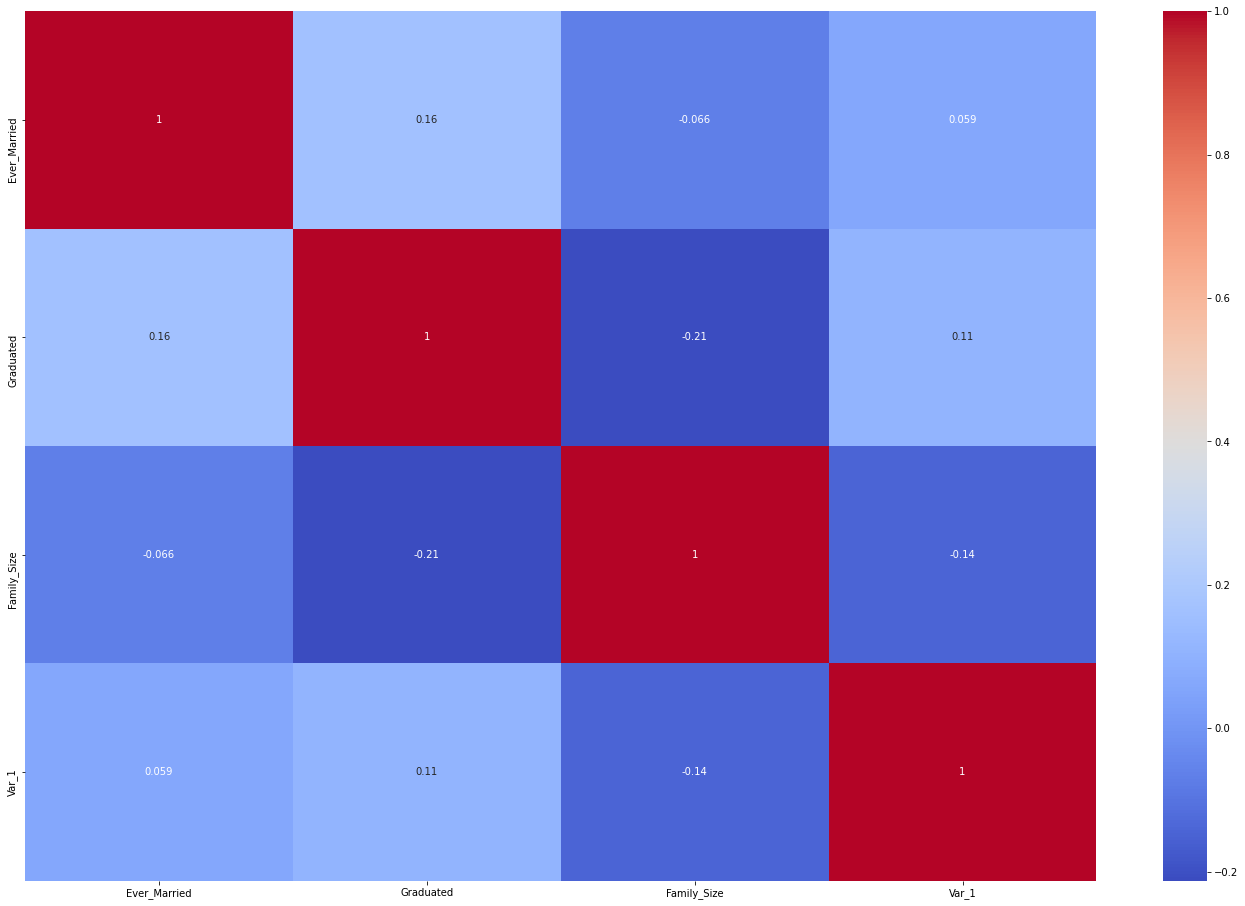

In [11]:
plt.figure(figsize = (24,16))
sns.heatmap(pd.concat([df,Y], axis=1).corr(), annot=True, cmap="coolwarm")

Not great features here, but lets see how we go...  
The only ones that look reasonable are Gender, Ever_Married, Agem Graduated and maybe Work_Experience. You usually prefer these to be above 0.3.

# Get X/Y into arrays

Now copy out our X and y columns into matrix's for easier matrix manipulation later.

In [12]:
X = df.to_numpy()  # np.matrix(df.to_numpy())
y = Y.to_numpy().transpose()  # np.matrix(Y.to_numpy()).transpose()

m,n = X.shape

# Normalise X  

Now, lets normalise X so the values lie between -1 and 1. We do this so we can get all features into a similar range. We use the following equation  

$X_{(i)} = \frac{x_{(i)}-mean(x)}{max(x)-min(x)}$  
  
The goal to perform standardization is to bring down all the features to a common scale without distorting the differences in the range of the values. This process of rescaling the features is so that they have mean as 0 and variance as 1.


In [13]:
mu = X.mean(0) # 
sigma = X.std(0) # standard deviation: max(x)-min(x)
xn = (X - mu) / sigma

Add a column of ones to X for easier matrix manipulation of our hypothesis and cost function later

In [14]:
xo = np.hstack((np.ones((m, 1)), xn))

# Setup our neural network

Then, we can setup the sizes of our neural network, first, below is the neural network we want to put together.  
![title](neuralnetwork.png)

Below initialisations, ensure above network is achieved. So, now you are asking "What are reasonable numbers to set these to?"  
  
`Input layer`   = set to the size of the dimensions  
`Hidden layers` = set to input_layer * 2  
`Output layer`  = set to the size of the labels of Y. In our case, this is 7 categories  


In [15]:
input_layer_size = n                    # Dimension of features
hidden_layer_size = input_layer_size*2  # of units in hidden layer 
output_layer_size = len(yle.classes_)     # number of labels

# Initialise weights  

Now, we can initialise our weights to random small values (remember these are also called theta’s). For gradient descent, its OK to initalise to zero's, but for neural networks, it works out better if we initialise our weights to some random values. Here we develop a handy function to perform the initialization.  

In [16]:
def initializeWeights(L_in, L_out):
    epsilon_init = 0.12
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
    return W

In [17]:
initial_Theta1 = initializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = initializeWeights(hidden_layer_size, output_layer_size)
nn_params = np.concatenate((initial_Theta1.flatten(), initial_Theta2.flatten()), axis=None)

# Sigmoid functions  

Since we are doing classification, we will use sigmoid to evaluate our predictions. A sigmoid function is a mathematical function having a characteristic "S"-shaped curve or sigmoid curve. A common example of a sigmoid function is the logistic function shown in the first figure and defined by the formula  

$$sigmoid(z) = g(z) = \frac{1}{1 + e^{-z}}$$
$$g'(z) = \frac{d}{dz}g(z) = g(z)\left(1 - g(z)\right)$$

In checknn.py the following handy functions are created:  
  
- sigmoid is a handy function to compute sigmoid of input parameter Z
- sigmoidGradient computes the gradient of the sigmoid function evaluated at z. This should work regardless if z is a matrix or a vector.

# Regularization  

We will implement regularization as one of the most common problems data science professionals face is to avoid overfitting. Overfitting gives you a situation where your model performed exceptionally well on train data but was not able to predict test data. Neural network are complex and makes them more prone to overfitting. Regularization is a technique which makes slight modifications to the learning algorithm such that the model generalizes better. This in turn improves the model’s performance on the unseen data as well.  

If you have studied the concept of regularization in machine learning, you will have a fair idea that regularization penalizes the coefficients. In deep learning, it actually penalizes the weight matrices of the nodes.  
We implement regularization in nnCostFunction by passing in a lambda which us used to penalise both the gradients and costs that are calculated. 

# Cost function  

We need a function which can implements the neural network cost function for a two layer neural network which performs classification.  
In checknn.py out costfunction will return  

- gradient should be a "unrolled" vector of the partial derivatives of the neural network  
- the final J which is the cost of this weight.   

Our cost function will do the following:  

- Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices for our 2 layer neural network
- Perform forward propagation to calculate (a) and (z)
$${\left(\Theta_{ji}^{(l)}\right)^2} = -\frac{1}{m}trace\left(y^T\log\left(h_\Theta(X)\right) + ({\bf1} - y)^T\log\left({\bf1} - h_\Theta(X)\right)\right) + \frac{\lambda}{2m}\sum_{l=1}^{L-1}\sum_{i=1}^{s_l}\sum_{j=1}^{s_{l+1}}{\left(\Theta_{ji}^{(l)}\right)^2}$$ 
- Calculate the cost of our forward propagation into J and apply regularization 
$$J(\theta) = -\frac{1}{m}\left[\sum_{i=1}^{m}\sum_{k=1}^{K}{y_k^{(i)}\log\left(h_\Theta(x^{(i)})_k\right) + (1 - y_k^{(i)})\log\left(1 - h_\Theta(x^{(i)})_k\right)}\right] + \frac{\lambda}{2m}\sum_{l=1}^{L-1}\sum_{i=1}^{s_l}\sum_{j=1}^{s_{l+1}}$$  
- Perform backward propagation to calculate (s) and apply regularization 
$$\Delta_{ij}^{(l)} = \sum_m{a_j^{(l)}\delta_i^{(l+1)}}$$
$$D^{(l)} = \frac{1}{m}\Delta^{(l)} + \frac{\lambda}{m}\Theta^{(l)}$$

# Checking our forward/backward propagation  

One difficult thing to understand is if our cost function is performing well. A good method to check this is to run a function called checknn.  
Creates a small neural network to check the backpropagation gradients, it will output the analytical gradients produced by your backprop code and the numerical gradients (computed using computeNumericalGradient). These two gradient computations should result in very similar values.  

If you want to delve more into the theory behind this technique, it is tought in Andrew Ng's machine learning course, week 4.  
You do not need to run this every time, just when you have setup your network.  

In [18]:
from checknn import *

print('Checking Backpropagation... ')
# Weight regularization parameter (we set this to 1 here).
lambda_ = 1
#  Check gradients by running checkNNGradients
checkNNGradients(lambda_)

Checking Backpropagation... 
[[ 0.01231622  0.01231622]
 [ 0.01835978  0.01835978]
 [ 0.00308386  0.00308386]
 [-0.01502735 -0.01502735]
 [ 0.00392471  0.00392471]
 [-0.00539821 -0.00539821]
 [ 0.013362    0.013362  ]
 [ 0.01983725  0.01983725]
 [-0.00808459 -0.00808459]
 [-0.01084911 -0.01084911]
 [-0.02002159 -0.02002159]
 [-0.01078632 -0.01078632]
 [-0.01266691 -0.01266691]
 [ 0.01965602  0.01965602]
 [ 0.01276025  0.01276025]
 [-0.00586723 -0.00586723]
 [-0.00559343 -0.00559343]
 [-0.01521978 -0.01521978]
 [ 0.00275391  0.00275391]
 [ 0.01819567  0.01819567]
 [ 0.30934772  0.30934772]
 [ 0.17925309  0.17925309]
 [ 0.14985892  0.14985892]
 [ 0.14313253  0.14313253]
 [ 0.13843822  0.13843822]
 [ 0.14164805  0.14164805]
 [ 0.108133    0.108133  ]
 [ 0.07595054  0.07595054]
 [ 0.06019342  0.06019342]
 [ 0.04385492  0.04385492]
 [ 0.03530847  0.03530847]
 [ 0.0410438   0.0410438 ]
 [ 0.10627037  0.10627037]
 [ 0.07557325  0.07557325]
 [ 0.06356257  0.06356257]
 [ 0.04812245  0.04812245]

In [20]:
from checknn import *

print('Checking Cost Function (w/ Regularization) ... ')
J, g = nnCostFunction2(nn_params, input_layer_size, hidden_layer_size, output_layer_size, xn, y, lambda_)

print(f'Cost at parameters (loaded from ex4weights): {J:f} \n(this value should be about 1.776110)')
g

Checking Cost Function (w/ Regularization) ... 
Cost at parameters (loaded from ex4weights): 4.750065 
(this value should be about 1.776110)


array([-4.71288530e-02,  1.15842288e-05,  1.27618038e-03, -1.00906170e-03,
        4.43930999e-02,  9.15343351e-04,  1.53670660e-03, -2.11333507e-03,
        9.38017822e-03,  2.09403915e-04,  1.04677218e-03, -1.00886451e-03,
        5.18981757e-03,  9.22723870e-05,  2.05542839e-05,  7.07695517e-05,
       -1.96338116e-02, -7.96087057e-04, -9.13479209e-04,  1.72130288e-03,
       -1.77325777e-02, -6.38499846e-04, -7.55967580e-04,  9.31852203e-04,
        4.32034666e-01,  2.12340775e-01,  2.12607757e-01,  2.24529225e-01,
        2.18576220e-01,  2.19125262e-01,  2.26178311e-01,  4.06260453e-01,
        1.99690454e-01,  1.99071151e-01,  2.11055358e-01,  2.06377605e-01,
        2.05257600e-01,  2.12513021e-01,  3.65839437e-01,  1.82450288e-01,
        1.78957503e-01,  1.91092464e-01,  1.86117909e-01,  1.84389365e-01,
        1.91239587e-01,  4.82509357e-01,  2.36992252e-01,  2.36550711e-01,
        2.50562969e-01,  2.44908984e-01,  2.43893424e-01,  2.52649411e-01,
       -1.48695011e-01, -

In [21]:
print('Training Neural Network... ')

#  Change the MaxIter to a larger value to see how more training helps.
options = {'maxiter': 50, 'disp': True}

#  You should also try different values of lambda
lambda_ = 1;

# Create "short hand" for the cost function to be minimized
fun = lambda nn_params: nnCostFunction2(nn_params, input_layer_size, hidden_layer_size, output_layer_size, xn, y, lambda_)[0]
jac = lambda nn_params: nnCostFunction2(nn_params, input_layer_size, hidden_layer_size, output_layer_size, xn, y, lambda_)[1]

# Now, costFunction is a function that takes in only one argument (the neural network parameters)
from scipy import optimize as opt
res = opt.minimize(fun, nn_params, method='CG', jac=jac, options=options)
nn_params = res.x
cost = res.fun

print(res.message)

Training Neural Network... 
         Current function value: 1.776139
         Iterations: 50
         Function evaluations: 113
         Gradient evaluations: 113
Maximum number of iterations has been exceeded.


In [22]:
# Obtain Theta1 and Theta2 back from nn_params
Theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].reshape((hidden_layer_size, input_layer_size + 1))
Theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):].reshape((output_layer_size, hidden_layer_size + 1))

print(cost)

1.7761103659320405


In [23]:
pred = predict(Theta1, Theta2, X)

print(f'Training Set Accuracy: {(pred == y).mean() * 100:f}')

Training Set Accuracy: 65.427928
